## **Creating a RAG Pipeline**
Creating a RAG pipelime that that uses a PDF to answer the queries based on the context of the PDF file, by the use of an LLM.

In [ ]:
# # Perform Google Colab installs (if running in Google Colab)
# import os

# if "COLAB_GPU" in os.environ:
#     print("[INFO] Running in Google Colab, installing requirements.")
#     !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
#     !pip install PyMuPDF # for reading PDFs with Python
#     !pip install tqdm # for progress bars
#     !pip install sentence-transformers # for embedding models
#     !pip install accelerate # for quantization model loading
#     !pip install bitsandbytes # for quantizing models (less storage space)
#     !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

## Document/Text Processing and Embedding Creation

### Importing the PDF Document

In [ ]:
import os
import requests

# get pdf path
pdf_path = "human-nutrition-text.pdf"

# download PDF
if not os.path.exists(pdf_path):
  print("[INFO] File does not exist!")

  # Enter the url of the pdf
  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  # the local filename to save the downloaded file
  filename = pdf_path

  # send a GET request to the url
  response = requests.get(url)

  # check if the request was successful
  if response.status_code == 200:

    # Open the file in binary mode and save it
    with open(filename, "wb") as file:
      file.write(response.content)
    print(f"[INFO] the file has been downloaded and saved as {filename}")
  else:
    print(f"[INFO] failed to download the file. Status code: {response.status_code}")

else:
  print("[INFO] File already exists!")


[INFO] File does not exist!
[INFO] the file has been downloaded and saved as human-nutrition-text.pdf


In [ ]:
# !pip show tqdm

In [ ]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 72.1 MB/s eta 0:00:00


In [ ]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
  """
  Performs minor formatting on text
  """
  cleaned_text = text.replace("\n", " ").strip() # replaces the new lines with a spacing hence turning the text into a paragraph and then '.strip()' method removes any leading and trailing whitespace characters

  return cleaned_text

# Open PDF and get lines/pages
# Only focuses on text rather than images or figures
def open_and_read_pdf(pdf_path: str) -> list[dict]:
  """
  Opens a PDF file, read its text content page by page, and collects statistics.
  Parameters: pdf_path(str): the file path to the PDF document to be opened and read.

  Returns: list[Dict]: A list of dictionaries, each containing the page number (adjusted),
           character count, word count, sentence count, token count and the extracted text for each page.
  """
  doc = fitz.open(pdf_path) # Opens the document
  pages_and_texts = []

  # 'page_number' is not extracted from the text content of the page. It's simply the index of the page in the file, as handled by PyMuPDF.
  for page_number, page in tqdm(enumerate(doc)): # iterate through the document pages
    text = page.get_text() # get plain text encoded as UTF-8 (per page)
    text = text_formatter(text=text)
    pages_and_texts.append({"page_number": page_number - 41, # PDF starts on page 42
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(". ")),
                            "page_token_count": len(text)/4, # 1 token ~= 4 characters
                            "text": text})
  return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:3]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': -39,
  'page_char_count': 320,
  'page_word_count': 54,
  'page_sentence_count_raw': 1,
  'page_token_count': 80.0,
  'text': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE'}]

In [ ]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 821,
  'page_char_count': 2138,
  'page_word_count': 405,
  'page_sentence_count_raw': 21,
  'page_token_count': 534.5,
  'text': 'the nipple. Groups of alveoli connected by ducts are organized into  lobes, or sections, of the breast. The breast contains 15 to 25 lobes,  and each lobe contains 10 to 100 alveoli.  The areola is the darker skin around the nipple and is a visual  target that helps the baby find the breast. The bumps on the areola  are glands that provide lubrication and protection to the tissue.  These glands also produce a scent to help the baby find the nipple.  The nipple and areola contain erectile smooth muscles that contract  to make the nipple protrude more during breastfeeding. Nipples  come in many sizes and shapes and contain from 4 to 18 openings  for the milk to flow out. Mothers do not need to do anything to get  their nipples ready to breastfeed.  Breast size is mainly determined by the amount of fat in the  breast; the milk-making structure

### Getting some stats on the text (EDA)

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [ ]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


### Further preprocessing of texts, (splitting pages into sentences)
Breaking texts into chunks of sentences, i.e. chunk s page into groups of 5, 7, 10 or more sentences.
```
Ingest text -> split into groups/chunks -> embed the groups/chunks -> use the embeddings
```
Some options for splitting text into sentencees:
1. Split into sentences with simple rule (e.g. split on "." with `text.split(".")`).
2. Split into sentences with a natural language processing (NLP) library such as spaCy or nltk.

Why split into sentences?:
- Easier ti handle than larger pages of text (especially if pages are densely filled with text).
- Can get specific and find which group of sentences were used to help within a RAG pipeline.

In [ ]:
# Practice
from spacy.lang.en import English
word_say = "Today I went to the market to get some artichokees. To be honest, I have never tasted any before, but I was eager to. While I was in the market, I saw something very interesting. A child that was shredded to the max!! I also met Dr. Thatcher, was also in the scene surprisingly."
nlp = English()
nlp.add_pipe("sentencizer")
doc = nlp(text=word_say)
for sent in doc.sents:
  print(sent.text)

Today I went to the market to get some artichokees.
To be honest, I have never tasted any before, but I was eager to.
While I was in the market, I saw something very interesting.
A child that was shredded to the max!!
I also met Dr. Thatcher, was also in the scene surprisingly.


In [ ]:
# Using parser (prcatice)
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(word_say)
for sent in doc.sents:
  print(sent.text)

Today I went to the market to get some artichokees.
To be honest, I have never tasted any before, but I was eager to.
While I was in the market, I saw something very interesting.
A child that was shredded to the max!!
I also met Dr. Thatcher, was also in the scene surprisingly.


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp("Research consistently demonstrates that LLMs are highly sensitive o subtle variations in prompt formatting, structure, and linguistic properties. Some studies have shown up to 76 accuracy points across formatting changes in few-shot settings. [31] Linguistic features significantly influence prompt effectiveness—such as morphology, syntax, and lexico-semantic changes—which meaningfully enhance task performance across a variety of tasks. Clausal syntax, for example, improves consistency and reduces uncertainty in knowledge retrieval. [33] This sensitivity persists even with larger model sizes, additional few-shot examples, or instruction tuning.")
for sent in doc.sents:
  print(sent.text)

Research consistently demonstrates that LLMs are highly sensitive o subtle variations in prompt formatting, structure, and linguistic properties.
Some studies have shown up to 76 accuracy points across formatting changes in few-shot settings.
[31] Linguistic features significantly influence prompt effectiveness—such as morphology, syntax, and lexico-semantic changes—which meaningfully enhance task performance across a variety of tasks.
Clausal syntax, for example, improves consistency and reduces uncertainty in knowledge retrieval.
[33] This sensitivity persists even with larger model sizes, additional few-shot examples, or instruction tuning.


In [ ]:
from spacy.lang.en import English

nlp = English()

# Add sentencizer pipeline
nlp.add_pipe("sentencizer")

# Create a doucment instance
doc = nlp("Whether you’re trying to fix a BSOD such as a IRQL_NOT_LESS_OR_EQUAL or a CRITICAL_PROCESS_DIED error, serious Windows troubleshooting is like plunging down the rabbit hole in Alice in Wonderland. At some point you may feel like you’ve taken on more than you can handle, you’re in a strange place, and the ultimate outcome is far from certain. That’s why I always keep track of the time I spend on troubleshooting, with a definite exit strategy in mind. Should the weeds get too thick to hack through, or the circumstances become too vexing or dire, that exit strategy will work to solve most problems that require troubleshooting in the first place.")

assert len(list(doc.sents)) == 4

# Access the sentences of the document
list(doc.sents)

[Whether you’re trying to fix a BSOD such as a IRQL_NOT_LESS_OR_EQUAL or a CRITICAL_PROCESS_DIED error, serious Windows troubleshooting is like plunging down the rabbit hole in Alice in Wonderland.,
 At some point you may feel like you’ve taken on more than you can handle, you’re in a strange place, and the ultimate outcome is far from certain.,
 That’s why I always keep track of the time I spend on troubleshooting, with a definite exit strategy in mind.,
 Should the weeds get too thick to hack through, or the circumstances become too vexing or dire, that exit strategy will work to solve most problems that require troubleshooting in the first place.]

In [ ]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 863,
 'page_word_count': 136,
 'page_sentence_count_raw': 8,
 'page_token_count': 215.75,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5.\xa0Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.  \xa0https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitami

In [ ]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)

  # Make sure all sentences are strings (the default tyoe is a spaCy datatype)
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]

  # Count the sentences
  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 299,
  'page_char_count': 763,
  'page_word_count': 126,
  'page_sentence_count_raw': 5,
  'page_token_count': 190.75,
  'text': 'n/a  Note that removing the lipid elements from food also takes away  the food’s fat-soluble vitamin content. When products such as grain  and dairy are processed, these essential nutrients are lost.  Manufacturers replace these nutrients through a process called  enrichment.  Learning Activities  Technology Note: The second edition of the Human  Nutrition Open Educational Resource (OER) textbook  features interactive learning activities.\xa0 These activities are  available in the web-based textbook and not available in the  downloadable versions (EPUB, Digital PDF, Print_PDF, or  Open Document).  Learning activities may be used across various mobile  devices, however, for the best user experience it is strongly  The Functions of Lipids in the Body  |  299',
  'sentences': ['n/a  Note that removing the lipid elements from food also takes awa

In [ ]:
# Turning a list of dictionaries into a dataframe to get some stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking sentences together
Grouping into 10 sentences for:
- Easier filtering (easier to inspect than large passages of text)
- Text to fit into the embedding model context window.
- So that context passed to the LLM can be more specific and focused.

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function to split lists of texts recursively into chunk size
# e.g. [20] -> [10,10] or [25] -> [10,10,5]
def split_list(input_list: list[str],
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:

  '''
  Splits the input_list into sublists of size slice_size (or as close as possible).
  For example a list of 17 sentences would be split into 2 lists of [[10], [7]]
  '''
  return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(input_list=test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [ ]:
# list(range(25))

In [ ]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
  item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                       slice_size=num_sentence_chunk_size)
  item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# Smple an example from the group (many samples have only 1 chunk since they've <= 10 sentences total)
import pprint
example = random.sample(pages_and_texts, k=1)
pprint.pprint(example)

[{'num_chunks': 1,
  'page_char_count': 1150,
  'page_number': 550,
  'page_sentence_count_raw': 9,
  'page_sentence_count_spacy': 9,
  'page_token_count': 287.5,
  'page_word_count': 197,
  'sentence_chunks': [['Water-Soluble Vitamins  UNIVERSITY OF HAWAI‘I AT MĀNOA '
                       'FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN '
                       'NUTRITION PROGRAM  All water-soluble vitamins play a '
                       'different kind of role in energy  metabolism; they are '
                       'required as functional parts of enzymes  involved in '
                       'energy release and storage.',
                       'Vitamins and minerals that  make up part of enzymes '
                       'are referred to as coenzymes and  cofactors, '
                       'respectively.',
                       'Coenzymes and cofactors are required by  enzymes to '
                       'catalyze a specific reaction.',
                       'They assist 

In [ ]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


Notice how the average number of chunks is around 1.5, this is expected since many of the pages only contain an average of 10 sentences.

### **Splitting each chunk into its own item**
- Embedding each chunk of sentences into its own numerical representation.

Creating a new list of dictionaries each containing a single chunk of sentences with realtive information such as page number as well as statistics about each chunk.

In [ ]:
import re

# Splitting each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
  for sentence_chunk in item["sentence_chunks"]:
    chunk_dict = {}
    chunk_dict["page_number"] = item["page_number"]

    # Join the list of sentences together into a paragraph-like structure
    joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
    joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)  # '.A' => '. A' for any full stop/capital letter combo


    chunk_dict["sentence_chunk"] = joined_sentence_chunk
    # Some stats on the chunk
    chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4

    pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [ ]:
# View a random sample
pprint.pprint(random.sample(pages_and_chunks, k=1))

[{'chunk_char_count': 128,
  'chunk_token_count': 32.0,
  'chunk_word_count': 21,
  'page_number': 684,
  'sentence_chunk': 'Learning activities may be used across various mobile '
                    'devices, however, for the best user experience it is '
                    'strongly 684 | Iodine'}]


In [ ]:
# Get the stats about the chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


### Filtering short chunks that may not contain useful information

In [ ]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25


In [ ]:
df.sample(4)

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
914,581,Age Group RDA Males and Females mcg DFE/day UL...,1028,152,257.00
624,388,Even a slight change in blood pH can affect bo...,1134,174,283.50
185,100,Major organs of the respiratory system The m...,909,141,227.25
1679,1071,Journal of the American Dietetic Association. ...,100,14,25.00


In [ ]:
# # Show random chunks with under 30 tokens in length
# min_token_length = 30
# for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
#   print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')


In [ ]:
# min_token_length = 30
# sampled_data = df[df['chunk_token_count'] <= min_token_length].sample(5)
# for _, row in sampled_data.iterrows():
#   print(f"Token count: {row['chunk_token_count']} | Text: {row['sentence_chunk']}")

In [ ]:
# Another alternative (for better performance)
min_token_length = 30
sampled_rows = df[df['chunk_token_count'] <= min_token_length].sample(5)
for token_count, text in zip(sampled_rows['chunk_token_count'], sampled_rows['sentence_chunk']):
  print(f"Token count: {token_count} | Text: {text}")

Token count: 20.75 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=283   Alcohol Metabolism | 441
Token count: 24.25 | Text: There are several lecithin supplements on the market Nonessential and Essential Fatty Acids | 315
Token count: 11.75 | Text: Accessed April 15, 2018. 1046 | Comparing Diets
Token count: 13.0 | Text: PART VII CHAPTER 7. ALCOHOL Chapter 7. Alcohol | 429
Token count: 20.75 | Text: Centers for Disease Control and Prevention.http://www.cdc.gov/nutrition/ Iron | 661


In [ ]:
# filter the dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient='records')
pprint.pprint(pages_and_chunks_over_min_token_len[:3])

[{'chunk_char_count': 308,
  'chunk_token_count': 77.0,
  'chunk_word_count': 42,
  'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT '
                    'MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN '
                    'TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM '
                    'MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, '
                    'JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA '
                    'NICOLE CHUN, AND ALLISON CALABRESE'},
 {'chunk_char_count': 210,
  'chunk_token_count': 52.5,
  'chunk_word_count': 30,
  'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at '
                    'Mānoa Food Science and Human Nutrition Program is '
                    'licensed under a Creative Commons Attribution 4.0 '
                    'International License, except where otherwise noted.'},
 {'chunk_char_count': 766,
  'chunk_toke

In [ ]:
from pprint import pprint
pprint(random.sample(pages_and_chunks_over_min_token_len, k=1))

[{'chunk_char_count': 813,
  'chunk_token_count': 203.25,
  'chunk_word_count': 119,
  'page_number': 529,
  'sentence_chunk': 'Food Serving Vitamin A (IU) Percent Daily Value Beef '
                    'liver 3 oz. 27,185 545 Chicken liver 3 oz. 12,325 245 '
                    'Milk, skim 1 c. 500 10 Milk, whole 1 c. 249 5 Cheddar '
                    'cheese 1 oz. 284 6 Source: Dietary Supplement Fact Sheet: '
                    'Vitamin A. National Institutes of Health, Office of '
                    'Dietary Supplements. '
                    'http://ods.od.nih.gov/factsheets/VitaminA-QuickFacts/. '
                    'Updated September 5, 2012. Accessed October 7, 2017. In '
                    'the United States, the most consumed carotenoids are '
                    'alpha- carotene, beta-carotene, beta-cryptoxanthin, '
                    'lycopene, lutein, and zeaxanthin. See Table 9.3 “Alpha- '
                    'and Beta-Carotene Content of Various Foods” for the '
 

In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
!pip show sentence-transformers

Name: sentence-transformers
Version: 4.1.0
Summary: Embeddings, Retrieval, and Reranking
Home-page: https://www.SBERT.net
Author: 
Author-email: Nils Reimers <info@nils-reimers.de>, Tom Aarsen <tom.aarsen@huggingface.co>
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: huggingface-hub, Pillow, scikit-learn, scipy, torch, tqdm, transformers, typing_extensions
Required-by: 


### **Embedding our text chunks**
- turn our text chunks into numberical representations, i.e. embeddings
- [Check this one](https://vickiboykis.com/what_are_embeddings/)
- We'll use the `sentence-transformers` library containing many pre-trained embedding models.
- Specifically getting the `all-mpnet-base-v2-` model.

In [ ]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")

# Demo: create a list of sentences
sentences = ["As a prelude to various talks on the Second World War, I often present the audience with four or five simple questions:",
             "These have usually been followed by a deathly silence and then by a hubbub of guesses and queries.",
             "Can you name the largest concentration camp that was operating in Europe in the years 1939–45?"]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

#See the embeddings
for sentence, embedding in embeddings_dict.items():
  print(f'Sentence: {sentence}')
  print(f'Embedding: {embedding}')
  print("")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: As a prelude to various talks on the Second World War, I often present the audience with four or five simple questions:
Embedding: [ 1.84401718e-03  1.78600568e-02 -3.03945318e-03  2.64702849e-02
 -2.61649545e-02 -1.41089587e-02  5.18734828e-02 -2.52858512e-02
 -2.95760594e-02  3.43006104e-02  2.82526892e-02 -3.18829454e-02
  1.41493743e-02 -6.86024725e-02  2.95842579e-03 -6.32662103e-02
  1.13455309e-02 -2.62533277e-02 -4.83552329e-02 -8.22658837e-03
 -4.37954115e-03 -2.36368291e-02 -1.36126559e-02  2.35214410e-03
  1.59881040e-02  1.33995130e-03 -3.77814919e-02 -2.70541641e-03
  1.15736434e-02 -4.48933430e-02  2.59671006e-02  1.66392676e-03
  2.97982693e-02 -6.91137388e-02  1.42084878e-06  1.86434574e-03
  1.20025780e-02  1.69751998e-02 -3.44730578e-02 -2.31601223e-02
  3.89231890e-02  1.31119313e-02  1.53560741e-02 -4.29370953e-03
 -2.86190640e-02 -2.22878233e-02  2.11714245e-02  7.86997452e-02
  1.95003077e-02  3.78811471e-02  2.62612407e-03  5.81825618e-04
 -1.68104153e-

In [ ]:
print(f'Embedding shape: {embedding.shape}')

Embedding shape: (768,)


In [ ]:
embeddings[0].shape # dimension

(768,)

In [ ]:
# Performing embedding using cpu
# %%time

# embedding_model.to("cpu")

# for item in tqdm(pages_and_chunks_over_min_token_len):
#   item["embedding"] = embedding_model.encode(item["sentence_chunk"])

In [ ]:
# performing embedding using gpu
%%time

# Send the model to the GPU
embedding_model.to("cuda")

# Creates embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
  item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 37.6 s, sys: 462 ms, total: 38.1 s
Wall time: 58.6 s


In [ ]:
%%time

# Turn the text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
pprint(text_chunks[:3])

['Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE '
 'AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO '
 'CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, '
 'JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND '
 'ALLISON CALABRESE',
 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science '
 'and Human Nutrition Program is licensed under a Creative Commons Attribution '
 '4.0 International License, except where otherwise noted.',
 'Contents Preface University of Hawai‘i at Mānoa Food Science and Human '
 'Nutrition Program and Human Nutrition Program xxv About the Contributors '
 'University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and '
 'Human Nutrition Program xxvi Acknowledgements University of Hawai‘i at Mānoa '
 'Food Science and Human Nutrition Program and Human Nutrition Program xl '
 'Part\xa0I.\xa0Chapter 1. Basic Concepts in Nutrition Intr

In [ ]:
len(text_chunks)

1680

In [ ]:
%%time

# embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # batch size (for speed/performance)
                                               convert_to_tensor=True, # Optional to return embeddings as tensor instead as array
                                               show_progress_bar=True)
text_chunk_embeddings

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

CPU times: user 17.4 s, sys: 114 ms, total: 17.5 s
Wall time: 25.1 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [ ]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 277,
 'sentence_chunk': 'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture 

In [ ]:
text_chunks[:3]

['Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
 'Contents Preface University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxv About the Contributors University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxvi Acknowledgements University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xl Part\xa0I.\xa0Chapter 1. Basic Concepts in Nutrition Introduction University of Hawai‘i at Mānoa Food

### Save the embeddings to file (csv)

In [ ]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
# Import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


Where to find the idea on which embedding model to use, look at the [Hugging Face Massive Text Embedding (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)

Forms of text chunking/splitting there are, look at this [LangChain's options](https://python.langchain.com/docs/how_to/#text-splitters)

> **What to think about when creating embeddings**
- Size of the input - choose a model with larger input capacity if need to embed longer sequences.
- Size of the embedding vector - larger is better but requires more compute/storage.
- Size of the model - larger models generally results in better embeddings but requires more compute power/time.
- Open or closed - open models allow one to run on their own hardware whereas closed models can be easeire to setup but requires an API call to get embeddings.

> **Where to store embeddings**
For small dataset, say relatively under 100,000 embeddings, `np.array` or `torch.tensor` can work relatively fine.

For a larger setup with greater than 100,000 embeddings, a `vector database` will help.

## **RAG - search and answer**
The whole idea of RAG is to get an LLM to be more factually correct based on your own input as well as have a reference to where the generated output may have come from.
- **Retrieval** - get relevant resources given a query.
- **Augmentation** - In augmentation, we pass relevant information into the prompt and get an LLM to use that relevant information as the basis of its generation.
- **Generation** - LLM generates a response that has been flavoured/augmented with the retrieved resources.
***

### Similarity Search
- Similiarity search, vector search, semantic search.

In [ ]:
import random
import torch
import numpy as np
import ast
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# import texts and embeddings df
text_chunks_and_embeddings_df = pd.read_csv(embeddings_df_save_path)

# convert embedding column back to np array (got converted to string when stored in csv)
# text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(ast.literal_eval).apply(np.array)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# ****** Convert our embeddings to tensor and to float32 ******* (You get a PyTorch tensor ready for model input or similarity comparison.)
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype=torch.float32).to(device) # (.tolist()) converts the series of numpy array to a list of numpy arrays

# -------------------------------------------------------------------------------------------------------------------------------------------------------
# convert texts and embeddings df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

# pages_and_chunks
text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."
...,...,...,...,...,...,...
1675,1164,Flashcard Images Note: Most images in the flas...,1305,176,326.25,"[0.0185622536, -0.0164277665, -0.0127045633, -..."
1676,1164,Hazard Analysis Critical Control Points reused...,375,51,93.75,"[0.0334720612, -0.0570440851, 0.0151489386, -0..."
1677,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1286,173,321.50,"[0.0770515501, 0.00978557579, -0.0121817412, 0..."
1678,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,59,102.50,"[0.103045158, -0.0164701864, 0.00826846063, 0...."


In [ ]:
text_chunks_and_embeddings_df["embedding"]

,embedding
0,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,"[0.0330264494, -0.0084976349, 0.00957159605, -..."
...,...
1675,"[0.0185622536, -0.0164277665, -0.0127045633, -..."
1676,"[0.0334720612, -0.0570440851, 0.0151489386, -0..."
1677,"[0.0770515501, 0.00978557579, -0.0121817412, 0..."
1678,"[0.103045158, -0.0164701864, 0.00826846063, 0...."


In [ ]:
embeddings.shape # [num_chunks, embedding_dim]

torch.Size([1680, 768])

In [ ]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2',
                                      device = device)

### Creating a small semantic search pipeline:
- Define the query string.
- Turn the query string into an embedding (with the same model used to embed the text chunks).
- Perform a `dot product` or `cosine similarity` function between the text embeddings and the query embedding.
- Sort the results from 3 in descending order.

*NOTE* : when using a dot product for comparison, ensure vector sizes are of same shape (768) & tensors/vectors are in the same datatype (both in float32)

***Exhaustive search***
- `dot product` majorly focuses on the magnitude of the vector as opposed to `cosine similarity` that majorly focuses on the direction of the vector.
  - Use dot product when magnitude matters (e.g., weighted scoring).
  - Use cosine similarity when you care about semantic alignment, not scale — e.g., comparing text embeddings, where length may vary but direction (meaning) is key.

In [ ]:
# 1. Define the query
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query
# It's important to embed your query with the same model you embed your passages with
query_embedding = embedding_model.encode(query,
                                         convert_to_tensor=True).to(device)
query_embedding = query_embedding.unsqueeze(0) # Shape is [1, 768]
print(f"Query embedding shape: {query_embedding.shape}\n")

# 3. Get similarity scores with the dot product (use cosine similarity if outputs of model aren't normalized)
from time import perf_counter as timer

start_time = timer()
# dot_scores = torch.matmul(embeddings, query_embedding.T).squeeze(1)
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0] # Shape ([1680,]) -> (num_chunks,)
end_time = timer()

print(f"[INFO] The shape of dot scores: {dot_scores.shape} -> (num_chunks)\n")
print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.\n")

# 4. Get the top-k results (we'll keep top 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product # returns a tuple (top_values, top_indices)

Query: macronutrients functions
Query embedding shape: torch.Size([1, 768])

[INFO] The shape of dot scores: torch.Size([1680]) -> (num_chunks)

[INFO] Time taken to get scores on 1680 embeddings: 0.05514 seconds.



torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
indices=tensor([42, 47, 41, 51, 46], device='cuda:0'))

In [ ]:
dot_scores

tensor([0.4343, 0.4406, 0.3667,  ..., 0.3941, 0.3321, 0.3707], device='cuda:0')

In [ ]:
# Pulling the matching chunks
top_idxs = torch.topk(dot_scores, k=5).indices
# Taking the integers of the top_idxs to the cpu by the use of .item() method
top_chunks = [text_chunks_and_embeddings_df['sentence_chunk'][i.item()] for i in top_idxs]
pprint(top_chunks)

['Macronutrients Nutrients that are needed in large amounts are called '
 'macronutrients. There are three classes of macronutrients: carbohydrates, '
 'lipids, and proteins. These can be metabolically processed into cellular '
 'energy. The energy from macronutrients comes from their chemical bonds. This '
 'chemical energy is converted into cellular energy that is then utilized to '
 'perform work, allowing our bodies to conduct their basic functions. A unit '
 'of measurement of food energy is the calorie. On nutrition food labels the '
 'amount given for “calories” is actually equivalent to each calorie '
 'multiplied by one thousand. A kilocalorie (one thousand calories, denoted '
 'with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on '
 'nutrition food labels. Water is also a macronutrient in the sense that you '
 'require a large amount of it, but unlike the other macronutrients, it does '
 'not yield calories. Carbohydrates Carbohydrates are molecules comp

*Demo for larger embeddings*

In [ ]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print("Embeddings shape: ", larger_embeddings.shape)

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")


Embeddings shape:  torch.Size([168000, 768])
[INFO] Time taken to get scores on 168000 embeddings: 0.00049 seconds.


For larger datasets, the use of dedicated vector database/indexing libraries is used for easier retrieval instead of exhaustive search. Faiss as an example (check [here](https://github.com/facebookresearch/faiss) for more information)

In this case the `indices` can be used to map back to the text chunks.

Using the indices in `torch.topk()` to map back the chunks.

Therefore, firstly, we define a small helper fucntion to print out wrapped text (so it doesn't print a whole text chunk as a single line (like the one above 😅))

In [ ]:
text

'Centers for Disease Control and Prevention.http://www.cdc.gov/nutrition/ Iron | 661'

In [ ]:
# define a helper function to print wrapped text
import textwrap

def print_wrapped(text:str, wrap_length=80):
  wrapped_text = textwrap.fill(text, wrap_length)
  print(wrapped_text)

## Getting the indices
Looping through the `top_results_dot_product` tuple and match the scores and indices and then use those indices to index `pages_and_chunks` variable to get the relevant text chunk.

In [ ]:
query = "macronutrients functions"
print(f"Query: '{query}'\n")
print("Results: ")

# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
  print(f"Score: {score:.4f}")
  # Print the most relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
  print("Text: ")
  print_wrapped(pages_and_chunks[idx]["sentence_chunk"])

  # print the page numnber too for referencing the textbook further (and check the results)
  print(f"Page number: {pages_and_chunks[idx]['page_number']}")
  print("\n")

Query: 'macronutrients functions'

Results: 
Score: 0.6926
Text: 
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
ar

In [ ]:
embeddings.shape

torch.Size([1680, 768])

Loading the page number conatining the highest result

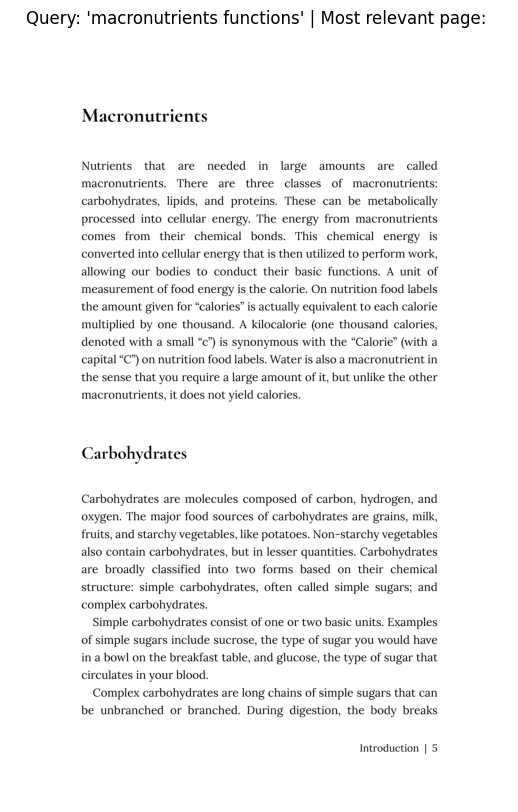

In [ ]:
import fitz
import matplotlib.pyplot as plt

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" #
doc = fitz.open(pdf_path)
page = doc.load_page(5+41) # the number of page starts from page 41

# get the image of the page
img = page.get_pixmap(dpi=300)

# img.save("output_filename.png")
doc.close() # close the document to prevent data leakage

# Convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, # memory view object
                          dtype = np.uint8).reshape((img.h, img.w, img.n)) # Converts a raw image byte buffer (1D) into a proper 3D NumPy array image of shape (height, width, channels)

# display the image using Matplotlib
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page: ")
plt.axis('off') #turn off the axis
plt.show()

**Workflow**
```
ingest documents -> split into chunks -> embed chunks -> make a query -> embed the query -> compare the embedded query
to chunk embeddings
```


### Similarity measures: dot product and cosine similarity
- cosine similarity is usually used for semantic search in texts, it's just a dot product that has the magnitude/vector normalised; it removes magnitude from the equation and focuses solely on the direction.

- `Dot product` - `torch.dot`, `np.dot`, `sentence_transformers.utils.dot_score`
- `Cosine Similarity` - `torch.nn.functional.cosine_similarity`, `1 - scipy.spatial.distance.cosine` (subtract the distance from 1 for similarity measure), `sentnce_transformer.util.cos_sim`
  - For text similarity, you generally want to use cosine similarity since you are after the semantic measurements (direction) rather than magnitude.
  - In this case, the embedding model `all-mpnet-base-v2` outputs are already normalised therefore dot product and cosine similarity return the same results. However, dot product is faster due to no need to perform normalization step.

In [ ]:
# Making a simple dot product and cosine similarity functions and view their results on different vectors
import torch
def dot_product(vector1, vector2):
  return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
  dot_product = torch.dot(vector1, vector2)

  # get the Euclidean/L2 norm
  norm_vector1 = torch.norm(vector1)
  norm_vector2 = torch.norm(vector2)

  return dot_product / (norm_vector1 * norm_vector2)

# Example vectors/tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# calculate dot product
print(f"Dot product between vector 1 and vector2: {dot_product(vector1, vector2)}")
print(f"Dot product between vector 1 and vector3: {dot_product(vector1, vector3)}")
print(f"Dot product between vector 1 and vector4: {dot_product(vector1, vector4)}")

print("\n")

# calculate cosine similarity (normalised magnitude)
print(f"Cosine similarity between vector1 and vector2: {cosine_similarity(vector1, vector2)}")
print(f"Cosine similarity between vector1 and vector3: {cosine_similarity(vector1, vector3)}")
print(f"Cosine similarity between vector1 and vector4: {cosine_similarity(vector1, vector4)}")

Dot product between vector 1 and vector2: 14.0
Dot product between vector 1 and vector3: 32.0
Dot product between vector 1 and vector4: -14.0


Cosine similarity between vector1 and vector2: 0.9999999403953552
Cosine similarity between vector1 and vector3: 0.9746317863464355
Cosine similarity between vector1 and vector4: -0.9999999403953552


### Functionizing the semantic search pipeline
Putting all of the above steps for the semantic search into a function

In [ ]:
def retrieve_relevant_resources(query: str,
                               embeddings: torch.tensor,
                               model: SentenceTransformer = embedding_model,
                               n_resource_to_return: int=5,
                               print_time: bool=True):
  """
  Embeds a query with model and returns top-k scores and indices from embeddings
  """
  # embed the query
  query_embedding = model.encode(query, convert_to_tensor=True)

  # get the dot product scores in embeddings
  start_time = timer()
  dot_scores = util.dot_score(query_embedding, embeddings)[0]
  end_time = timer()

  if print_time:
    print(f"[INFO] time taken to get scores on ({len(embeddings)} embedings: {end_time - start_time:.5f} seconds.)")

  scores, indices = torch.topk(input=dot_scores, k=n_resource_to_return)

  return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
  """
  Find relevant passages given a query and prints them out along with their scores.
  """
  scores, indices = retrieve_relevant_resources(query=query,
                                                embeddings=embeddings,
                                                n_resource_to_return=n_resources_to_return)

  print(f"Query: {query}\n")
  print("Results:\n")
  # loop through zipped together scores and indices from torch.topk
  for score, idx in zip(scores, indices):
    print(f"Score: {score:.4f}")
    # Print the most relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text: ")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])

    # print the page numnber too for referencing the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

In [ ]:
query="foods rich in ascorbic acid"
# retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] time taken to get scores on (1680 embedings: 0.00009 seconds.)
Query: foods rich in ascorbic acid

Results:

Score: 0.5872
Text: 
Dietary Sources of Vitamin C Citrus fruits are great sources of vitamin C and so
are many vegetables. In fact, British sailors in the past were often referred to
as “limeys” as they carried sacks of limes onto ships to prevent scurvy. Vitamin
C is not found in significant amounts in animal- based foods. Because vitamin C
is water-soluble, it leaches away from foods considerably during cooking,
freezing, thawing, and canning. Up to 50 percent of vitamin C can be boiled
away. Therefore, to maximize vitamin C intake from foods, you should eat fruits
and vegetables raw or lightly steamed. For the vitamin C content of various
foods, see Table 9.12 “Vitamin C Content of Various Foods”. Table 9.12 Vitamin C
Content of Various Foods Food Serving Vitamin C (mg) Percent Daily Value Orange
juice 6 oz. 93 155 Grapefruit juice 6 oz. 70 117 Orange 1 medium 70 117
S

## ***Getting an LLM for local generation***
LLMs are designed to generate an output given an input. In this case, we want the LLM to generate an output of text based on the context of relevant information to the query.

We'll augment our prompt with a query as well as context from the textbook related to that query.

> **The question of which LLM to use**
2 of the main questions to ask is:
1. Do I want it to run locally?
2. If yes, how much compute power can I dedicate?

To decide on which LLM model to use (run locally) check [here](https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard#/?params=0%2C3) and [here](https://huggingface.co/TheBloke)

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes/1024**3, 1)
print("Available GPU memory: ", gpu_memory_gb," GB")

Available GPU memory:  14.7  GB


In [ ]:
!nvidia-smi

Tue Jun  3 23:05:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             33W /   70W |    2058MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
if gpu_memory_gb < 5.1:
  print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
  print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
  use_quantization_config = True
  model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
  print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
  use_quantization_config = False
  model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
  print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 7B in 4-bit or float16 precision.")
  use_quantization_config = False
  model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 14.7 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


## Loading an LLM locally
Going to need few things:
1. A quantization config - a config on what precision to load the model in (e.g. 8-bit, 4-bit, e.t.c.)
2. A model ID - this will tell transformers which model/tokenizer to load.
3. A tokenizer - this turns text into numbers ready for the LLM (a tokenizer is different from an embedding model).
4. An LLM model - this will be what is used to generate text based on input!

In [ ]:
!pip install -q bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.9 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers.utils import is_flash_attn_2_available

# 1. Create a quantization config
# 1pip install bitsnadbytes accelerate
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2 "
else:
  attn_implementation = "sdpa" # scaled dot product attention (still speeds up the attention mechanism in transformer architecture)

# 2. Pick the model to use
model_id = "google/gemma-2b-it"

# 3. Instantiate tokenizer (tokenizer turns text into tokens)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False, #use as much memory as we can
                                                 attn_implementation=attn_implementation)
if not use_quantization_config:
  llm_model.to("cuda")

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
print(f"Using attention implementation: {attn_implementation}")

Using attention implementation: sdpa


In [ ]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

In [ ]:
# getting the parameters
def get_model_num_params(model: torch.nn.Module):
  return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [ ]:
def get_model_mem_buffer_size(model: torch.nn.Module):
  # Get model parameters and buffer sizes
  mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
  mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

  # calculate model sizes
  model_mem_bytes = mem_params + mem_buffers
  model_mem_mb = model_mem_bytes / (1024**2)
  model_mem_gb = model_mem_bytes / (1024**3)

  return{"model_mem_byte" : model_mem_bytes,
         "model_mem_mb" : round(model_mem_mb, 2),
         "model_me_gb" : round(model_mem_gb, 2)}

get_model_mem_buffer_size(llm_model)

{'model_mem_byte': 5012345344, 'model_mem_mb': 4780.15, 'model_me_gb': 4.67}

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

## **Generating text with LLM**
> It is important to use the tokenizer that has been paired with your model.

> There's a specific template you should pass for the ideal outputs.

In [ ]:
input_text = "What types of food are considered to be rich in ascorbic acid? And what is the role of ascorbic acid in the body?"
print(f"Input text:\n{input_text}")

# create a prompt template for instructions-tuned model (helper function)
dialogue_template = [{
    "role":"user",
    "content":input_text
}]
# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # Keep as raw text (not tokenized)
                                       add_generation_prompts=True)
print(f"\nPrompt:\n{prompt}")

Input text:
What types of food are considered to be rich in ascorbic acid? And what is the role of ascorbic acid in the body?

Prompt:
<bos><start_of_turn>user
What types of food are considered to be rich in ascorbic acid? And what is the role of ascorbic acid in the body?<end_of_turn>



- Next is tokenizing this formatted text and pass it to the model's `generate()` method.
- Make sure the tokenised text is on the same device as the model

In [ ]:
%%time

# tokenize the input text and send it to device
input_ids = tokenizer(prompt, return_tensors="pt").to('cuda')
print(f"Model tokenized:\n {input_ids}\n")

# generate output passed on the tokenized input
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) #define the maximum number of tokens to create
print("Model outputs:\n ",outputs[0])

Model tokenized:
 {'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,   5088,    576,   2960,
            708,   5604,    577,    614,   7277,    575, 208322,   6898, 235336,
           1474,   1212,    603,    573,   4731,    576, 208322,   6898,    575,
            573,   2971, 235336,    107,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model outputs:
  tensor([     2,      2,    106,   1645,    108,   1841,   5088,    576,   2960,
           708,   5604,    577,    614,   7277,    575, 208322,   6898, 235336,
          1474,   1212,    603,    573,   4731,    576, 208322,   6898,    575,
           573,   2971, 235336,    107,    108,    186,    201,  13641,   8777,
         29203,    576,   1877, 138371,  31481,    210,    193,    109,   2169,
        138371,   6898, 235269,   1170,   3836,    685,  23042,    585, 235269,
      

- Converting the output tokens to text using `tokenizer.decode()`

In [ ]:
outputs_decoded = tokenizer.decode(outputs[0])   # skip_special_tokens=True
print(f"Model output decoded: \n")
pprint(outputs_decoded)

Model output decoded: 

('<bos><bos><start_of_turn>user\n'
 'What types of food are considered to be rich in ascorbic acid? And what is '
 'the role of ascorbic acid in the body?<end_of_turn>\n'
 '<h2><b>Rich Food Sources of Ascorbic Acid</b></h2>\n'
 '\n'
 'Ascorbic acid, also known as vitamin C, is a water-soluble vitamin that is '
 'essential for good health. It is involved in many important bodily '
 'functions, including:\n'
 '\n'
 '* **Immune function:** Ascorbic acid helps the body fight off infections by '
 'boosting the production of white blood cells.\n'
 '* **Collagen production:** It is essential for the production of collagen, a '
 'protein that is found in skin, bones, and cartilage.\n'
 '* **Iron absorption:** Ascorbic acid helps the body absorb iron from food.\n'
 '* **Tissue repair:** It helps to repair damaged tissue and promote wound '
 'healing.\n'
 '* **Energy production:** Ascorbic acid is involved in the production of '
 'energy in the body.\n'
 '\n'
 'Here are s

Replacing the the prompt in the output text.
> `"<bos>"` and `"<eos>"` are special tokens to denote "beginning oof sentence" and "end of sentence" repectively.

In [ ]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What types of food are considered to be rich in ascorbic acid? And what is the role of ascorbic acid in the body?

Output text:
<h2><b>Rich Food Sources of Ascorbic Acid</b></h2>

Ascorbic acid, also known as vitamin C, is a water-soluble vitamin that is essential for good health. It is involved in many important bodily functions, including:

* **Immune function:** Ascorbic acid helps the body fight off infections by boosting the production of white blood cells.
* **Collagen production:** It is essential for the production of collagen, a protein that is found in skin, bones, and cartilage.
* **Iron absorption:** Ascorbic acid helps the body absorb iron from food.
* **Tissue repair:** It helps to repair damaged tissue and promote wound healing.
* **Energy production:** Ascorbic acid is involved in the production of energy in the body.

Here are some of the richest food sources of ascorbic acid:

* **Citrus fruits:** Oranges, grapefruits, lemons, and limes are all excellent s

In [ ]:
# nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrient, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What roles does fiber play in digestion? name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "Water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrient, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What roles does fiber play in digestion? name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'Water soluble vitamins']

In [ ]:
import random

query = random.choice(query_list)
print(f"Query: {query}")

# get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What is the RDI for protein per day?
[INFO] time taken to get scores on (1680 embedings: 0.00007 seconds.)


(tensor([0.6793, 0.6771, 0.6418, 0.6109, 0.5908], device='cuda:0'),
 tensor([ 609,  607, 1007,  608, 1005], device='cuda:0'))

## **Augmenting prompt with context items**
- Prompt engineering: augmenting a prompt with context items.

Prompting techniques to be used:
1. Give clear instructions.
2. Give a few examples of input/output (e.g. given this input, I'd like this output).
3. Give room to think (e.g. "create a scratchpad"/"show your working space"/"let's think step by step...")

In [ ]:
# pages_and_chunks[indices[0]]

In [ ]:
# creating a function to format a prompt with context items
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
  # create a prompt template for instructions-tuned model (helper function)
  context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

  # Create a base prompt with examples to help the model
  # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
  # We could also write this in a txt file and import it in if we wanted.
  base_prompt = """Based on the following context items, please answer the query.
  Give yourself room to think by extracting relevant passages from the context before answering the query.
  Don't return the thinking, only return the answer.
  Make sure your answers are as explanatory as possible.
  Use the following examples as reference for the ideal answer style.
  \nExample 1:
  Query: What are the fat-soluble vitamins?
  Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use.
  Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health.
  Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
  \nExample 2:
  Query: What are the causes of type 2 diabetes?
  Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity.
  Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin.
  Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes.
  Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
  \nExample 3:
  Query: What is the importance of hydration for physical performance?
  Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells.
  Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke.
  Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
  \nNow use the following context items to answer the user query:
  {context}
  \nRelevant passages: <extract relevant passages from the context here>
  User query: {query}
  Answer:"""

  # Update base prompt with context items and query
  base_prompt = base_prompt.format(context=context, query=query)

  # create prompt template for instruction-tuned model
  dialogue_template = [{
      "role":"user",
      "content": base_prompt
  }]

  # Apply the chat template
  prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                         tokenize=False, # Keep as raw text (not tokenized)
                                         add_generation_prompts=True)

  return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings = embeddings)

# create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# format the prompt
prompt = prompt_formatter(query=query, context_items=context_items)
print(f"\nPrompt:\n{prompt}")


Query: What roles does fiber play in digestion? name five fibre containing foods.
[INFO] time taken to get scores on (1680 embedings: 0.00008 seconds.)

Prompt:
<bos><start_of_turn>user
Based on the following context items, please answer the query.
  Give yourself room to think by extracting relevant passages from the context before answering the query.
  Don't return the thinking, only return the answer.
  Make sure your answers are as explanatory as possible.
  Use the following examples as reference for the ideal answer style.
  
Example 1:
  Query: What are the fat-soluble vitamins?
  Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use.
  Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health.
  Vitamin E acts as an antioxidant, protecting 

In [ ]:
# [item["sentence_chunk"] for item in context_items]

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors='pt').to('cuda')

# generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # increasing the temperature leads to more randomness, encouraging more diverse or creative outputs
                             do_sample=True,  # whether or not to use sampling
                             max_new_tokens=256) # how many new tokens to generate from the prompt

# turn the output tokens into text
output_text = tokenizer.decode(outputs[0])
print(f"Query: {query}\n")
# print(f"Output text:\n{output_text.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What roles does fiber play in digestion? name five fibre containing foods.

RAG answer:
<bos>Fiber plays a crucial role in digestion by acting as a dietary fiber. Dietary fiber is categorized as either water-soluble or insoluble. Soluble fibers, such as inulin, pectin, and guar gum, are more easily accessible to bacterial enzymes in the large intestine, allowing for faster digestion. On the other hand, insoluble fibers, such as cellulose and lignin, require more energy for digestion due to their larger molecular structure.<eos>
CPU times: user 3.31 s, sys: 10.2 ms, total: 3.32 s
Wall time: 3.43 s


## **Functionizing our LLM answering feature**
- RAG pipeline working on a single function!
- Entails inputing a query and getting a generated answer & optionally the source documents (the context) where the answer was generated from.

In [ ]:
# pages_and_chunks[575]

In [ ]:
def ask(query:str, temperature: float=0.7, max_new_tokens: int=256, format_answer_text: bool=True, return_answer_only=True):
  """
  Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
  """
  # RETRIEVAL -------------------------------------------------
  # get just the scores and indices of the top related results
  scores, indices = retrieve_relevant_resources(query=query,
                                                embeddings=embeddings)

  # create a list of context items
  context_items = [pages_and_chunks[i] for i in indices]

  # Add score to context item
  for i, item in enumerate(context_items):
    item["score"] = scores[i].cpu()

  # AUGMENTATION ------------------------------------------
  # Create the prompt and format it with context items
  prompt = prompt_formatter(query=query,
                            context_items=context_items)

  # GENERATION --------------------------------------------
  # Tokenize the prompt
  input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

  # generate an output of tokens
  outputs = llm_model.generate(**input_ids,temperature=temperature, do_sample=True, max_new_tokens=max_new_tokens)

  # Decode the tokens into text
  output_text = tokenizer.decode(outputs[0])

  # Format the answer
  if format_answer_text:
    # Replace prompt abd special tokens
    output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answered query:\n\n","")

  # Return asnwer only wihtout the context items
  if return_answer_only:
    return output_text
  else:
    return output_text, context_items

In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")
answer = ask(query=query,
        temperature=0.2,
        return_answer_only=True)

print("Answer:\n")
print_wrapped(answer)

Query: Explain the concept of energy balance and its importance in weight management.
[INFO] time taken to get scores on (1680 embedings: 0.00009 seconds.)
Answer:

  Energy balance is a state in which the intake of energy is equal to the
expenditure of energy. This means that the body is neither gaining nor losing
weight. Achieving and maintaining energy balance is crucial for physical
performance, as it ensures that the body has the energy it needs to function
properly. When energy intake is greater than expenditure, the body will store
the excess energy as fat. When energy expenditure is greater than intake, the
body will use its stores of fat and muscle tissue to maintain its weight.


**Refining the model**
- Having some kind of evaluation on how well the pipeline works.
- Use another LLM to rate the answers returned by this LLM and then use those ratings as proxy evaluations.
***
## Extensions (What to do)

* May want to improve text extraction with something like [Marker](https://github.com/VikParuchuri/marker)
* Guide to more advanced [PDF extraction](https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517)
* See the following prompt engineering resources for more prompting techniques - promptinguide.ai, Brex's Prompt Engineering Guide
* What happens when a query comes through that there isn't any context in the textbook on?
* Try another embedding model (e.g. Mixed Bread AI large, [`mixedbread-ai/mxbai-embed-large-v1`](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1))
* Try another LLM... (e.g. Mistral-Instruct)
* Try different prompts (e.g. see prompting techniques online)
* Our example only focuses on text from a PDF, however, we could extend it to include figures and images
* Evaluate the answers -> could use another LLM to rate our answers (e.g. use GPT-4 to make)
* Vector database/index for larger setup (e.g. 100,000+ chunks)
* Libraries/frameworks such as LangChain / LlamaIndex can help do many of the steps for you - so it's worth looking into those next, wanted to recreate a workflow with lower-level tools to show the principles
* Optimizations for speed
    * [See Hugging Face docs for recommended speed ups on GPU](https://huggingface.co/docs/transformers/perf_infer_gpu_one)
    * [Optimum NVIDIA](https://huggingface.co/blog/optimum-nvidia), [GitHub](https://github.com/huggingface/optimum-nvidia)
    * See [NVIDIA TensorRT-LLM](https://github.com/NVIDIA/TensorRT-LLM)
    * See [GPT-Fast for PyTorch-based optimizations](https://github.com/pytorch-labs/gpt-fast)
    * Flash attention 2 ([requires Ampere GPUs or newer](https://github.com/Dao-AILab/flash-attention))
* Stream text output so it looks prettier (e.g. each token appears as it gets output from the model)
* Turn the workflow into an app, see Gradio type chatbots for this - https://www.gradio.app/guides/creating-a-chatbot-fast, see [local example](https://www.gradio.app/guides/), creating-a-chatbot-fast#example-using-a-local-open-source-llm-with-hugging-face